Team members: 
* Fatou SALL
* Sebastion COUBE




In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Introduction

Le clustering sont des outils d'analyse des données qui permettent de grouper des échantillons, de sorte que les membres d'un même groupe (ou *cluster*) sont très similaires, alors que ceux de groupes différents ne le sont pas. Dans la suite, nous allons préciser explorer les méthodes spectrales. L'idée des méthodes spectrales est de **chercher les vecteurs propres associés aux avleurs propres les plus petites du laplacien**.

>-Soit $G = (V,E)$ un graphe non orienté avec $V$ l'ensemble des sommets et $E$ l'ensemble des arrets avec un poid non negative $w_{ij} ≥ 0$.


>-La matrice adjacente du graphe $G$ est la matrice $W = (w_{ij})$ $i,j=1,...,n$.

>-Le degrée d'un sommet $v_i \in V$ est defini par $d_i = \sum\limits_{j=1}^n w_{ij}$.

>-Le degrée matricielle $D$ est défini par une matrice diagonale ayant pour diagonales les degrées $d_1, . . . , d_n$:
$$
  D =
  \begin{bmatrix}
    d_{1} & & \\
    & \ddots & \\
    & & d_{n}
  \end{bmatrix}
$$.

### Graphe de similitude
Il y a plusieurs façon de transformer un ensemble donné de points $x_1, . . . , x_n$ doté d'une matrice de similarités $s_{ij}$ ou d'une matrice de distance $d_{ij}$ en un graphe. Lorsque l'on construit un graphe de similitude, le but est de modéliser la relation de voisin proche entre les points.

- Le **ε-voisinage graphe** : On connecte tous les points dont la distance l'un l'autre est plus petite que ε.

- Le **k-plus proche voisin graphe** : Ici le but est de connecter $v_i$ avec le sommet $v_j$ if $v_j$ est parmi les k-plus proches voisins de $v_i$ mais comme la relation de voisin n'est pas forcément symetrique, on considère deux différentes constructions.

    - Le **k-plus proche voisin graphe** : On ignore les directions des arêtes, on connecte $v_i$ et $v_j$ avec une arête non orientée si $v_i$ est parmi les k-plus proches voisins de $v_j$ ou si $v_j$ est parmi les k-plus proches voisins de $v_i$.
    - Le ** mutuel k-plus proche voisin graphe** : On connecte les sommets $v_i$ et $v_j$ si on a $v_i$ est parmi les k-plus proches voisins de $v_j$ et si $v_j$ est parmi les k-plus proches voisins de $v_i$.

- Le **graphe complet** : Ici on connecte simplement l'ensemble des points avec une similaritée positive, le poids de chaque arête étant $s_{ij}$.


### Graphe Laplaciens et leurs propriétés basiques 
#### Graphe laplacien non normalisé
La matrice du graphe Laplacien non normalisé est défini par $L = D − W$.

> - $ L \geq 0 $

> -  0 est une vakeur propre et $\mathbb{1}$ est le vecteur propre qui lui est associé 
> - les valeur propres sont positives:
$$ 0= \lambda_1 \leq \lambda_2 \leq  .............\leq \lambda_n $$
> -  Pour tout vecteur $f \in \mathbb{R}^n$ , on a

$$f^{'}Lf= \frac{1}{2} \sum_{i,j}^{n} w_{ij}(f_i-f_j)^2$$



> - la multiplicité de de la valeur propre 0 est égale aux nombres de composantes connexes du graphe G ($A_1,........,A_k$). De plus, l'espace propre associé à la valeur propre 0 de L est engendré par $\mathbb{1}_{A_1},..........,\mathbb{1}_{A_k}$.









#### Graphe laplacien normalisé
         
         

Il y'a deux matrices utilisées pour définir le laplacien non normalisé: 
> - $L_{sym}: = D^{-\frac{1}{2}}L D^{-\frac{1}{2}}$

> -   $L_{RV}: = D^{-1}L $


### Application sur les données de Wikipedia

Nous aimerions savoir s'il est possible de détecter des communautés de pages simplement en regardant les liens hypertexte et de faire correspondre ces communautés avec des données du monde réel telles que les catégories de pages.



Nous utiliserons un sous-réseau du réseau d'hyperliens Wikipédia. Dans un tel graphe, chaque noeud est une page Wikipedia et il y a un lien entre le noeud $ a $ et le noeud $ b $ s'il y a un lien vers la page $ b $ sur la page $ a $.

#### Construction des graphes:


> - Commencez à partir d'une page racine arbitraire (préférez une page ambiguë afin d'obtenir autant de communautés différentes que possible).
> - Explorez cette page pour obtenir les liens intra-wiki: les premiers nœuds.
> - Pour chaque premier nœud, explorez les liens intra-wiki pour obtenir les deuxièmes nœuds.
> - Recherchez les connexions internes (liens de deuxièmes nœuds vers les premiers nœuds).
> - Finalement, pour chaque nœud, prenez l'intersection de son voisin avec les nœuds collectés (il se peut que certains nœuds aient des voisins qui n'ont pas été collectés, par exemple un deuxième nœud qui a été collecté depuis une page de désambiguïsation).


Pour chaque noeud, nous devons obtenir l'URL, le titre, les catégories et les liens vers d'autres pages


In [2]:
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import lil_matrix
import seaborn as sns
import networkx as nx
import operator
import community
from networkx.algorithms import community
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
import time
from networkx.drawing.nx_agraph import graphviz_layout
from scipy import linalg, cluster, sparse
from tqdm import tqdm_notebook
from utils import get_bag_of_communities

from utils import load_obj, save_obj

## Algorithme

### Etape 1  : Calcul du laplacien

In [3]:
def diag_matrice_degre(w):
    #print("0-Calcul de la matrice dégré d ..................... ")
    return np.diag(np.sum(w,axis=1))


def laplacien(w):
    print("0-Calcul de la matrice dégré d ..................... ")
    print("1-Calcul du laplacien ..................... ")
    return diag_matrice_degre(w)-w   

### Etape 2 : Calcul des k vecteurs associés aux k plus petites valeurs propres du laplacien

In [4]:
def k_vector_propre(L,k): 
    print("2-Calcul des {} vecteurs associés aux {} plus petites valeurs propres du laplacien ..................... ".format(k,k))
    eigenvalues, eigenvectors = np.linalg.eig(L)
    sorted_index = np.argsort(eigenvalues)
    eigenvectors=np.array(eigenvectors)
    
    plt.plot(np.sort(eigenvalues), '.-', color=sns.xkcd_rgb["mauve"])
    plt.title("Histogramme des valeurs propres")
    plt.imshow
    return eigenvectors[:,sorted_index[0:k]]
    


### Etape 3  : Partitionnement des vecteurs propres en avec kmeans

In [5]:
def spectralClustering(w,k,normalise=False):
    if normalise:
        n = w.shape[0]
        d = np.zeros((n, n))
        for i in range(n):
            d[i, i] = 1 / (w[i].sum())
            
        print("1-Calcul du laplacien ..................... ")     
        L =  np.sqrt(d).dot(w).dot(np.sqrt(d))
        x= k_vector_propre(L,k)
        Y = X / np.sum(X, 1)[:, np.newaxis]
        print("3-Partitionnement des vecteurs propres en avec kmeans ..................... ")
   
        return Kmeans(Y,k)
    else:
        
        L=laplacien(w)
        Y=k_vector_propre(L,k) 
        print("3-Partitionnement des vecteurs propres en avec kmeans ..................... ")
   
        return Kmeans(Y,k)

def initialize(X,K):
    print('Initialisation des clusters .....................\n ')
    centers = X[random.sample(range(0,(X.shape[0]-1)),K)]
    return centers

def assignment(X, centers):
    indx = []
    for point in X:
        norm = np.linalg.norm((centers-point), axis =1)
        indx.append(np.argmin(norm))
    return indx

def updateCenters(X,K,indx):

    newCenters = []
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        centroid = Cluster.mean(axis=0)
        newCenters.append(centroid)
    return newCenters

def AvgScore(X,K,indx,centers):
    score = []
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        distanceList = np.linalg.norm((Cluster-centers[clusterNumber]), axis =1)
        score.append(np.mean(distanceList))
            
    return score



def Kmeans(X,K,tol=0.0001,plot=False,stat=False):
    X = np.array(X)
    centers = initialize(X,K)
    indx = assignment(X, centers)
    AvgScore(X,K,indx,centers)
    Distortion = 1
    #print('Mis à jours des clusters .....................\n ')
    while Distortion > tol:
        newCenters = updateCenters(X,K,indx)
        newIndx = assignment(X, newCenters)
        
        scoreOld = AvgScore(X,K,indx,centers)
        scoreNew = AvgScore(X,K,newIndx,newCenters)
        
        Distortion = np.linalg.norm((np.array(scoreOld) - np.array(scoreNew)), axis =0)
        centers = newCenters
        indx = newIndx
        if stat:
            print('Score Old:',scoreOld,'\n')
            print('Score new:',scoreNew,'\n')
            print('Distortion:', Distortion)
            print('---------------------')
        
    if plot:
        DisplayPlot(X,K,centers,indx)
        
    return centers, indx, scoreNew

In [6]:
def DisplayPlot(X,K,centers,indx):
    colors = [ 'pink', 'red', 'yellow', 'red', 'orange', 'plum', 'navy', 'seagreen', 'pink', 'brown']
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        plt.scatter(Cluster[:,0],Cluster[:,1], marker='.' ,color=colors[clusterNumber])
        plt.scatter(np.array(centers)[clusterNumber,0],np.array(centers)[clusterNumber,1], marker='+' ,color='black')    
    plt.show()

In [7]:
def partitions(spectral_partition):
    partition = {}
    for i in range(k):
        comp=[]
        for title,labels in spectral_partition.items():
            if i==labels:
                comp.append(title)   
        partition[i]=set(comp)
    return list(partition.values())

## Application:

### Données simulées

In [8]:

from sklearn import cluster, datasets
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)
df = pd.DataFrame(noisy_moons[0]) ## convert to DF



#### Génération d'une matrice poids adjacente

In [9]:
def matrice_adjacente(X,gamma):
    n=X.shape[0]
    a=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            a[i,j] = math.exp(-math.pow(np.linalg.norm((X[i]-X[j]),2),2) * gamma)
    return a
def construct_W(X, Wtemp, k_neighbors):
    scores_matrix = lil_matrix(Wtemp)
    # knn_matrix is a sparse matrix
    knn_matrix = kneighbors_graph(X, k_neighbors, mode='connectivity', include_self=True)
    W = knn_matrix.multiply(scores_matrix)  # pointwise multiply
    return W.toarray()

#### Visualisation des données

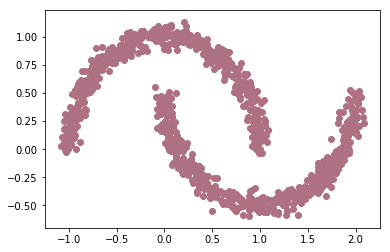

In [10]:


import matplotlib.pyplot as plt
plt.scatter(df[0],df[1],color=sns.xkcd_rgb["mauve"])
plt.show()

 #### Détection de communauté:

0-Calcul de la matrice dégré d ..................... 
1-Calcul du laplacien ..................... 
2-Calcul des 2 vecteurs associés aux 2 plus petites valeurs propres du laplacien ..................... 


C:\Anacond\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



3-Partitionnement des vecteurs propres en avec kmeans ..................... 
Initialisation des clusters .....................
 


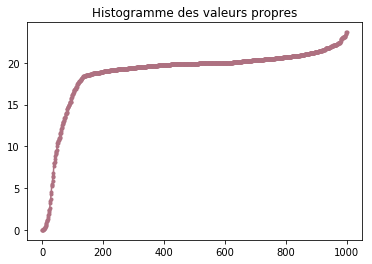

In [11]:
X = np.array(df)
A = matrice_adjacente(X,1)
w = construct_W(X,A,20)
centers_sim, indx_sim, score_sim = spectralClustering(w,2)


#### Visualition des communautés trouvées

C:\Anacond\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning:

Casting complex values to real discards the imaginary part



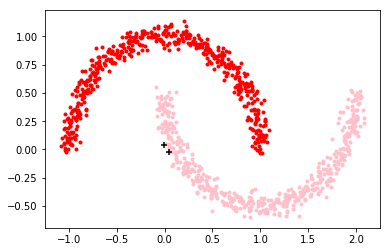

In [12]:
DisplayPlot(np.array(df),2,centers_sim,indx_sim)

### Application sur les données de Wikipedia

Nous aimerions savoir s'il est possible de détecter des communautés de pages simplement en regardant les liens hypertexte et de faire correspondre ces communautés avec des données du monde réel telles que les catégories de pages.



Nous utiliserons un sous-réseau du réseau d'hyperliens Wikipédia. Dans un tel graphe, chaque noeud est une page Wikipedia et il y a un lien entre le noeud $ a $ et le noeud $ b $ s'il y a un lien vers la page $ b $ sur la page $ a $.

#### Construction des graphes:


> - Commencez à partir d'une page racine arbitraire (préférez une page ambiguë afin d'obtenir autant de communautés différentes que possible).
> - Explorez cette page pour obtenir les liens intra-wiki: les premiers nœuds.
> - Pour chaque premier nœud, explorez les liens intra-wiki pour obtenir les deuxièmes nœuds.
> - Recherchez les connexions internes (liens de deuxièmes nœuds vers les premiers nœuds).
> - Finalement, pour chaque nœud, prenez l'intersection de son voisin avec les nœuds collectés (il se peut que certains nœuds aient des voisins qui n'ont pas été collectés, par exemple un deuxième nœud qui a été collecté depuis une page de désambiguïsation).


Pour chaque noeud, nous devons obtenir l'URL, le titre, les catégories et les liens vers d'autres pages

#### Création des graphes

In [15]:
from utils import explore_page

root_node = 'Jaguar (disambiguation)'

network = {}  # This dict stores for each page a dictionnary containing the keys [url, links, categories]
first_nodes = []

explore_page(root_node, network, first_nodes)

second_nodes = []
for node in first_nodes:
    explore_page(node, network, second_nodes)

all_nodes = list(network.keys()) + second_nodes
for link in tqdm_notebook(second_nodes):
    explore_page(link, network, [], inner=True, all_nodes=all_nodes)

all_nodes = list(network.keys()) + second_nodes
for link in tqdm_notebook(second_nodes):
    explore_page(link, network, [], inner=True, all_nodes=all_nodes)

all_nodes = list(network.keys())
for title in tqdm_notebook(network.keys()):
    network[title]['links'] = list(set(network[title]['links']).intersection(set(all_nodes)))



l = list(network.keys())
for i in l:
    if len(network[i]['links']) == 0:
        del network[i]



for i, title in enumerate(network.keys()):
    cats = network[title]['categories']
    new_cats = []
    for c in cats:
        if not c.startswith('Redundant') and not c.startswith('Pages') and not c.startswith('Webarchive') and not c.startswith('Wikipedia') and not c.startswith('Articles') and not c.startswith('Coordinates on Wikidata') and not 'Wikidata' in c and not c.startswith('CS1') and not c.startswith('EngvarB') and not c.startswith('All') and not c.startswith('Good articles') and not c.startswith('Use dmy'):
            new_cats.append(c)
    network[title]['categories'] = new_cats

In [16]:
# save_obj(network, 'network')
network = load_obj('network')

In [17]:
neighbors = {}
for i in network.keys():
    neighbors[i] = network[i]['links']

In [18]:
g = nx.Graph(neighbors)  # undirected graph

In [19]:
print('Le nombre de noeuds: {}'.format(len(g.nodes)))
print('Le nombre de sommets: {}'.format(len(g.edges)))
if nx.is_connected(g):
    print('Le graphe est connecté.')
else:
    print("Le graphe n'est pas connecté.")

Le nombre de noeuds: 6830
Le nombre de sommets: 367483
Le graphe est connecté.


In [20]:
w = nx.adjacency_matrix(g)
w.shape

(6830, 6830)

In [21]:
def matrice_adjacente(X):
    return nx.adjacency_matrix(X)

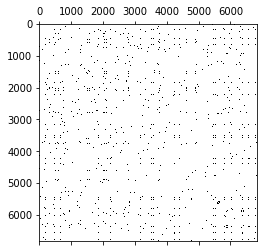

In [22]:

plt.spy(w.todense())


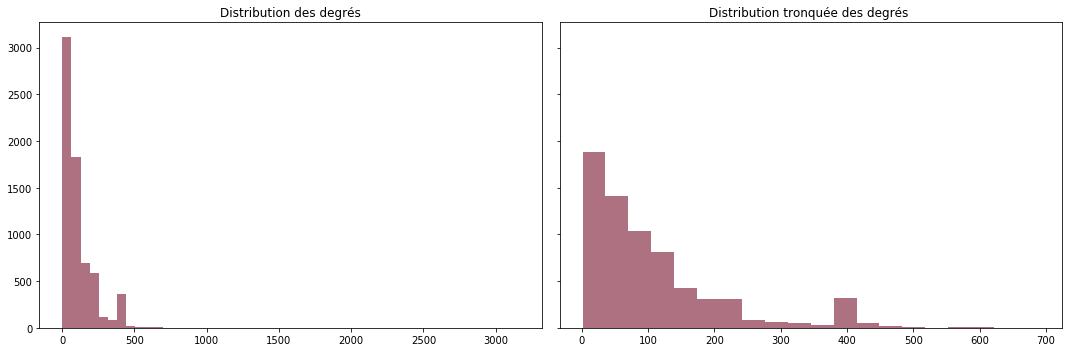

La moyenne des degrés est de: 107.55.


In [23]:
import numpy as np
degrees = np.array(w.sum(axis=1)).squeeze()
degrees_truncated = degrees[degrees < 700]
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Distribution des degrés')
ax[0].hist(degrees, bins=50,color=sns.xkcd_rgb["mauve"])

ax[1].set_title('Distribution tronquée des degrés ')
ax[1].hist(degrees_truncated, bins=20,color=sns.xkcd_rgb["mauve"])

plt.tight_layout()
plt.show()


avg_degree = np.mean(degrees)
print('La moyenne des degrés est de: {}.'.format(np.round(avg_degree, 2)))

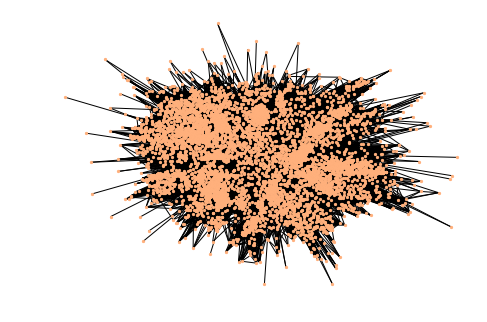

In [24]:
nx.draw(g, node_size=5, figsize=(15, 15),node_color=sns.xkcd_rgb["peach"])

#### Détection des communautés : Validation croisée pour le k optimal

0-Calcul de la matrice dégré d ..................... 
1-Calcul du laplacien ..................... 
2-Calcul des 2 vecteurs associés aux 2 plus petites valeurs propres du laplacien ..................... 


C:\Anacond\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



3-Partitionnement des vecteurs propres en avec kmeans ..................... 
Initialisation des clusters .....................
 


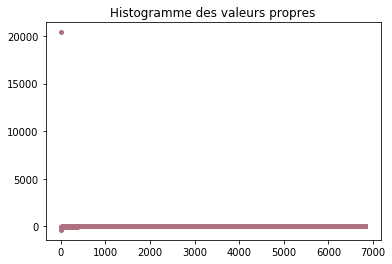

In [25]:
k=2
centroid , labels, score = spectralClustering(w,k)
spectral_partition = {}
for i, title in enumerate(network.keys()):
    spectral_partition[title] = labels[i]
partition=partitions(spectral_partition)
spectral_modularity = community.modularity(g,partition)


In [26]:
spectral_bag = get_bag_of_communities(network, spectral_partition)
spectral_counts = [0 for _ in range(k)]
for i, title in enumerate(spectral_partition.keys()):
    spectral_counts[spectral_partition[title]] += 1
for i in range(k):
    sorted_bag = sorted(spectral_bag[i].items(), key=operator.itemgetter(1), reverse=True)
    print(' ')
    print('Communité {}/{} ({} pages) : '.format(i+1, k, spectral_counts[i]))
    if spectral_counts[i] > 0:
        for ind in range(10):
            print(sorted_bag[ind])

 
Communité 1/2 (623 pages) : 
('IUCN Red List least concern species', 165)
('Carnivora stubs', 56)
('IUCN Red List vulnerable species', 41)
('Mammal genera', 36)
('Mammals of the United States', 36)
('Motor vehicle manufacturers of the United Kingdom', 35)
('Carnivorans of Africa', 35)
('Mammals of Asia', 34)
('Carnivorans of Malaysia', 34)
('Mammals described in 1758', 33)
 
Communité 2/2 (6207 pages) : 
('Formula One constructors', 123)
('Ship infoboxes without an image', 118)
('Jacksonville Jaguars players', 116)
('Formula One entrants', 115)
('Best Original Song Academy Award-winning songwriters', 114)
('Character pop', 110)
('Single-engined tractor aircraft', 102)
('Grammy Award winners', 95)
('Carrier-based aircraft', 92)
('Jacksonville Jaguars currentteam parameter articles', 86)


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

Partitionnement en 20 clusters:


Epoche 1/2
0-Calcul de la matrice dégré d ..................... 
1-Calcul du laplacien ..................... 
2-Calcul des 20 vecteurs associés aux 20 plus petites valeurs propres du laplacien ..................... 


C:\Anacond\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



3-Partitionnement des vecteurs propres en avec kmeans ..................... 
Initialisation des clusters .....................
 
Epoche 2/2
0-Calcul de la matrice dégré d ..................... 
1-Calcul du laplacien ..................... 
2-Calcul des 20 vecteurs associés aux 20 plus petites valeurs propres du laplacien ..................... 
3-Partitionnement des vecteurs propres en avec kmeans ..................... 
Initialisation des clusters .....................
 
la performation:0.7437976487750222
la modularité:0.5758965924335893
Durée: 935.9932732582092 seconds 
Partitionnement en 21 clusters:


Epoche 1/2
0-Calcul de la matrice dégré d ..................... 
1-Calcul du laplacien ..................... 
2-Calcul des 21 vecteurs associés aux 21 plus petites valeurs propres du laplacien ..................... 


C:\Anacond\lib\site-packages\numpy\linalg\linalg.py:1151: RuntimeWarning:

invalid value encountered in equal



3-Partitionnement des vecteurs propres en avec kmeans ..................... 
Initialisation des clusters .....................
 


C:\Anacond\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning:

Mean of empty slice.

C:\Anacond\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars

C:\Anacond\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning:

Mean of empty slice.

C:\Anacond\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning:

invalid value encountered in true_divide



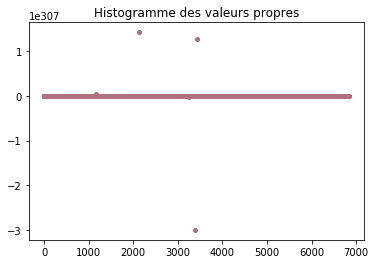

In [29]:
from networkx.algorithms import community
cross_val_modularity = {}
cross_val_performance = {}
for k in tqdm_notebook(range(10, 30)):
    print("Partitionnement en {} clusters:".format(k))
    print("\n")

    start_time=time.time()
    tmp_modularity = []
    tmp_performance= []
    h=2
    for o in range(h):
        print("Epoche {}/{}".format(o+1,h))
        centroid, labels, score = spectralClustering(w,k)
        spectral_partition = {}
        for i, title in enumerate(network.keys()):
            spectral_partition[title] = labels[i]
        partition=partitions(spectral_partition)
        spectral_modularity = community.modularity(g,partition)
        tmp_modularity.append(spectral_modularity)
              
        spectral_performance = community.performance(g,partition)
        tmp_performance.append(spectral_performance)
    print("la performation:{}".format(np.mean(tmp_performance)))
    print("la modularité:{}".format(np.mean(tmp_modularity)))
    cross_val_modularity[k] = [np.mean(tmp_modularity), np.std(tmp_modularity)]
    cross_val_performance[k] = [np.mean(tmp_performance), np.std(tmp_performance)]
    print("Durée: %s seconds " % (time.time() - start_time)) 
cross_val_modularity=save_obj(cross_val_modularity, 'cross_val_modularity')
cross_val_performance=save_obj(cross_val_performance, 'cross_val_performance')

In [30]:
cross_val = load_obj('cross_val')
print(cross_val)



{10: [0.5461446643531513, 0.014204021512990739], 11: [0.5384863265574735, 0.05735896525546241], 12: [0.5226832396829054, 0.06819879413736309], 13: [0.5533351870487171, 0.038818054236607814], 14: [0.5381651600658637, 0.04699507180368727], 15: [0.5865118737167674, 0.04360118280418143], 16: [0.5692134498770218, 0.03529209610081742], 17: [0.5865481270865698, 0.035536723142459904], 18: [0.5803603485387077, 0.05081587682393836], 19: [0.5864370773133469, 0.030512583730477282], 20: [0.5912985115025478, 0.01910266718815081], 21: [0.624789163803509, 0.026225410477092505], 22: [0.5861561201449181, 0.0356803881976126], 23: [0.5850799156459467, 0.021497274805815723], 24: [0.599679165273453, 0.00857302800808383], 25: [0.581851950930606, 0.05697908989489959], 26: [0.5611675652007942, 0.0396347612280689], 27: [0.5727729550668124, 0.025856710323085143], 28: [0.5791313467241119, 0.023406613568091705], 29: [0.5999388395947497, 0.02302581686076951]}


In [31]:
cross_val=pd.DataFrame.from_dict(cross_val)
cross_val=cross_val.transpose()
k_optimal=cross_val[0].idxmax(axis=0)
print(k_optimal)

21


0-Calcul de la matrice dégré d ..................... 
1-Calcul du laplacien ..................... 
2-Calcul des 21 vecteurs associés aux 21 plus petites valeurs propres du laplacien ..................... 


C:\Anacond\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



3-Partitionnement des vecteurs propres en avec kmeans ..................... 
Initialisation des clusters .....................
 
Durée: 175.17892026901245 seconds 


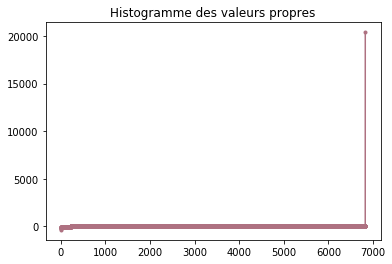

In [32]:
k=k_optimal
w = nx.adjacency_matrix(g)
start_time = time.time()
centroid_ , labels, score = spectralClustering(w,k)
print("Durée: %s seconds " % (time.time() - start_time))

#### Visualition des communautés

In [36]:

spectral_partition = {}
for i, title in enumerate(network.keys()):
    spectral_partition[title] = labels[i]

In [37]:
# spectral_partition = {}
for i, title in enumerate(network.keys()):
    #print(title)
    spectral_partition[title] = labels[i]


spectral_bag = get_bag_of_communities(network, spectral_partition)


spectral_counts = [0 for _ in range(k)]
for i, title in enumerate(spectral_partition.keys()):
    spectral_counts[spectral_partition[title]] += 1



for i in range(k):
    sorted_bag = sorted(spectral_bag[i].items(), key=operator.itemgetter(1), reverse=True)
    print(' ')
    print('Communauté {}/{} ({} pages) : '.format(i+1, k, spectral_counts[i]))
    if spectral_counts[i] > 0:
        for ind in range(10):
            print(sorted_bag[ind])

 
Communauté 1/21 (2163 pages) : 
('NFL player missing current team parameter', 48)
('Character pop', 46)
('Jaguar vehicles', 44)
('Jacksonville Jaguars players', 44)
('Infobox NFL biography articles missing alt text', 38)
('Rear-wheel-drive vehicles', 37)
('NFL player with coaching information', 36)
('Comics infobox without image', 34)
('Breguet aircraft', 32)
('Jacksonville Jaguars coaches', 30)
 
Communauté 2/21 (117 pages) : 
('Football team templates which use American parameter', 18)
('Professional baseball teams in Florida', 15)
('Soccer clubs in Florida', 13)
('Florida State League teams', 12)
('Soccer clubs in South Florida', 8)
('Team sports', 8)
('2015 establishments in Florida', 7)
('Sports in Jacksonville, Florida', 7)
('Roller derby leagues in Florida', 7)
('Soccer clubs in Miami', 7)
 
Communauté 3/21 (114 pages) : 
('Home video game consoles', 64)
('1990s toys', 22)
('1980s toys', 17)
('Second-generation video game consoles', 17)
('2000s toys', 17)
('Third-generation vi

In [38]:
community2color = {
    0: sns.xkcd_rgb["peach"],
    1: sns.xkcd_rgb["powder blue"],
    2: sns.xkcd_rgb["light pink"],
    3: sns.xkcd_rgb["chocolate"],
    4: sns.xkcd_rgb["orange"],
    5: sns.xkcd_rgb["magenta"],
    6: sns.xkcd_rgb["purple"],
    7: sns.xkcd_rgb["blue"],
    8: sns.xkcd_rgb["deep blue"],
    9: sns.xkcd_rgb["sky blue"],
    10: sns.xkcd_rgb["olive"],
    11: sns.xkcd_rgb["seafoam green"],
    12: sns.xkcd_rgb["tan"],
    13: sns.xkcd_rgb["mauve"],
    14: sns.xkcd_rgb["hot pink"],
    15: sns.xkcd_rgb["pale green"],
    16: sns.xkcd_rgb["indigo"],
    17: sns.xkcd_rgb["lavender"],
    18: sns.xkcd_rgb["eggplant"],
    19: sns.xkcd_rgb["brick"],
    20: sns.xkcd_rgb["light blue"],
}

In [39]:
position = nx.spring_layout(g)

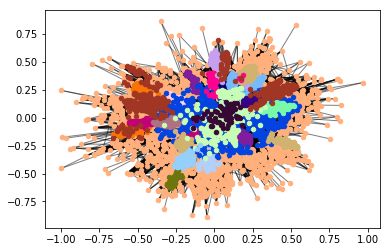

In [40]:


for community in set(spectral_partition.values()) :
    list_nodes = [nodes for nodes in spectral_partition.keys() if spectral_partition[nodes] == community]
    nx.draw_networkx_nodes(g, position, list_nodes, node_size=20, node_color=community2color[int(community)])

nx.draw_networkx_edges(g, position, alpha=0.5)
plt.show()



In [50]:
nx.set_node_attributes(g, spectral_partition, 'spectral')
nx.set_node_attributes(g, position, 'position')


In [54]:
from utils import build_communities, set_layout
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
tls.set_credentials_file(username='fatousall60@gmail.com', api_key='unRWpwhQd5zXXCdn58mT')

data = build_communities('spectral', 'position', G=g, community2color=community2color)
layout = set_layout('spectral clustering')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)



In [55]:
for i in spectral_partition.keys():
    spectral_partition[i] = str(spectral_partition[i])

In [56]:

for n, d in g.nodes(data=True):
    del d['position']


In [57]:
nx.write_graphml(g, 'data/full_graph.graphml')

## References

**[2]** von Luxburg, U., A Tutorial on Spectral Clustering, in *Statistics and Computing*, 17 (4), 2007.

